In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
sys.path.append('..')  # Add the 'graphlearning' package and pymig
import pymig

In [5]:
os.environ['THEANO_FLAGS']='floatX=float32'
import theano
import theano.tensor as T

In [6]:
import lasagne
from lasagne.layers import ExpressionLayer
import theano.tensor as T
import time
from graphlearning.graph_layers import GraphDenseLayer, GraphInitialLayer, GraphLayer
from graphlearning.graph_layers import ProjectionLayer, PairwiseProjectionLayer, PairwiseGraphDenseLayer
from graphlearning.graph_layers import GraphMoveProbLayer, SampleMoveLayer

ImportError: No module named 'graphlearning'

In [2]:
import pymig
N_nodes = 30
N_nodes_initial = 20
N_graph_inputs = 3
N_outputs_unary = pymig.get_nr_unary_moves()
N_outputs_binary = pymig.get_nr_binary_moves()
N_edge_types = pymig.get_nr_edge_types()

In [9]:
g = pymig.MigManager(40).create_random_graph(3,10)
for move_type in [2,3,4]:
    for i in range(g.get_total_nr_nodes()):
        for j in range(g.get_total_nr_nodes()):
            pymig.apply_move(g, pymig.PyMove(move_type,i,j))

AssertionError: MoveType doesn't correspond to nb of params

## Defining the graph-network

In [6]:
# Maximum size of the network
seed = 101
np.random.seed(seed)

# Input layer that receives the adjacency matrices
adj_matrices_layer = lasagne.layers.InputLayer((None, N_edge_types, N_nodes, N_nodes))
# Layer that initializes the first layer
layer_0 = GraphInitialLayer(adj_matrices_layer)
# Layer 1 with 10 features, bias and ReLU
layer_1 = GraphLayer(layer_0, adj_matrices_layer, 10, nonlinearity=lasagne.nonlinearities.rectify)#, b=None)
# Layer 2 with 25 features, bias and ReLU
layer_2 = GraphLayer(layer_1, adj_matrices_layer, 25, nonlinearity=lasagne.nonlinearities.rectify)#, b=None)
# Projecting to 12x25 features
layer_2_proj_pairwise = PairwiseProjectionLayer(layer_2)
# Dense layer for each node, N_outputs
output_layer_pairwise = PairwiseGraphDenseLayer(layer_2_proj_pairwise, N_outputs_binary, nonlinearity=None)

layer_2_proj = ProjectionLayer(layer_2, methods=['neighbour_max', 'neighbour_sum', 'self'])
# Dense layer for each node, N_outputs
output_layer = GraphDenseLayer(layer_2_proj, N_outputs_unary, nonlinearity=None)

# Compute distibution over possible moves
prediction_unary = lasagne.layers.get_output(output_layer)
prediction_binary = lasagne.layers.get_output(output_layer_pairwise)

move_mask_layer = lasagne.layers.InputLayer((None, None))

move_log_probability_layer = GraphMoveProbLayer([output_layer, output_layer_pairwise, move_mask_layer])
move_probability_layer = ExpressionLayer(move_log_probability_layer, lambda t: T.exp(t))

sample_move_layer = SampleMoveLayer(move_probability_layer, seed=seed-1)

# Gather all the params of the network
params = lasagne.layers.get_all_params([move_probability_layer], trainable=True)

# Reward
reward_value_var = T.matrix()
move_log_prob_var = lasagne.layers.get_output(move_log_probability_layer)

update_grad = T.grad(T.mean(T.sum(-reward_value_var*move_log_prob_var, axis=1), axis=0), params)

# Update function
#updates = lasagne.updates.nesterov_momentum(update_grad, params, learning_rate=0.001, momentum=0.9)
updates = lasagne.updates.adam(update_grad, params, learning_rate=0.005)
l2_norm = lasagne.regularization.regularize_network_params(move_probability_layer, lasagne.regularization.l2)

In [7]:
print("Number of parameters in the network : {}".format(lasagne.layers.count_params([output_layer,output_layer_pairwise])))

Number of parameters in the network : 3365


In [8]:
next_move_fn = theano.function([adj_matrices_layer.input_var, move_mask_layer.input_var],
                               lasagne.layers.get_output(sample_move_layer))
train_fn = theano.function([adj_matrices_layer.input_var, move_mask_layer.input_var, reward_value_var
                           ], [], updates=updates)

In [9]:
pred_fn = theano.function([adj_matrices_layer.input_var], [prediction_unary, prediction_binary])
prob_fn = theano.function([adj_matrices_layer.input_var, move_mask_layer.input_var], lasagne.layers.get_output(move_probability_layer))

In [10]:
l2_norm_fn = theano.function([], l2_norm)

## Useful functions for data generation

In [11]:
# Generate the starting graphs
def generate_random_graphs(batch_size, mig_manager, num_input, N_nodes):
    return [mig_manager.create_random_graph(num_input, N_nodes) for i in range(batch_size)]

def generate_random_mig_decomps(batch_size, mig_manager, num_input):
    return [mig_manager.random_mig_decomposition(num_input) for i in range(batch_size)]

def get_move_from_ind(ind, n_nodes_padded):
    return pymig.PyMove(*move_log_probability_layer.get_position_from_ind(ind, n_nodes_padded))

# Apply the operations, get a new list of graphs and say if a move was invalid
def apply_moves(graphs, command_ind, n_nodes_padded):
    next_graphs, command_validity = [], []
    for g, c_ind in zip(graphs, command_ind):
        move = get_move_from_ind(c_ind, n_nodes_padded)
        g_nb_nodes = g.get_total_nr_nodes()
        
        g_2 = pymig.apply_move(g, move)

        if g_2 is None:
            command_validity.append(False)
            next_graphs.append(g)
        else:
            command_validity.append(True)
            # if graph too big use the previous one
            if g_2.get_total_nr_nodes() > n_nodes_padded:
                g_2 = g
            next_graphs.append(g_2)
    return next_graphs, np.array(command_validity)

from data_utils import pad
# Get the full tensor from the list of graphs
def get_adj_tensor(graphs, max_N_nodes=-1):
    adj_tensors = [g.get_adjacency_tensor() for g in graphs]
    if max_N_nodes < 0:
        max_N_nodes = np.max([t.shape[1] for t in adj_tensors])
    adj_tensors = pad(adj_tensors, size=(None, max_N_nodes, max_N_nodes))
    return np.stack(adj_tensors).astype(np.float32)

def get_move_mask(graphs, max_N_nodes):
    move_masks = [move_log_probability_layer.make_move_mask(*g.get_move_inds(), max_N_nodes) for g in graphs]
    return np.stack(move_masks).astype(np.float32)

def make_training_data_from_reward(command_ind_history, command_validity_history, rewards,
                                   nb_moves=N_nodes**2*N_outputs_binary+N_nodes*N_outputs_unary, discount_factor=1):
    # Only care up to best obtained case
    inds = rewards.cumsum(axis=1).argmax(axis=1)
    rewards_cropped = rewards.copy()
    for i in range(rewards.shape[0]):
        rewards_cropped[i,inds[i]+1:]=0
    
    reward_move_masks = []
    reward_values = []
    nb_graphs, rollout_steps = rewards_cropped.shape
    #normalized_rewards = rewards - np.mean(rewards)
    discount_range = discount_factor**np.arange(rollout_steps)[None, :]
    action_rewards = np.cumsum((rewards_cropped * discount_range)[:, ::-1], axis=1)[:,::-1] / discount_range
    # Go through time
    
    #for command_ind, command_validity in zip(command_ind_history, command_validity_history):
    for step in range(rollout_steps):
        #nb_graphs = command_ind_history.shape[1]#len(command_validity)
        reward_value = np.zeros((nb_graphs, nb_moves), dtype=np.float32)
        
        # Patch for when numerical instabilities for command_ind
        #is_command_ind_in = command_ind_history[:, step] < nb_moves
        #reward_value[(np.arange(nb_graphs)[is_command_ind_in], command_ind_history[is_command_ind_in, step])] = action_rewards[is_command_ind_in, step
                                                                                                                              
        reward_value[(np.arange(nb_graphs), command_ind_history[:, step])] = action_rewards[:, step]

        # Invalid commands
        #reward_value[(np.arange(nb_graphs)[~command_validity], command_ind[~command_validity])] = 0#-0.1
        
        reward_values.append(reward_value)
    return np.concatenate(reward_values)

In [13]:
mig_manager = pymig.MigManager()
graphs = generate_random_mig_decomps(20, mig_manager, N_graph_inputs)
test_batch = get_adj_tensor(graphs, N_nodes)
test_move_mask = get_move_mask(graphs, N_nodes)
test_batch.shape, test_move_mask.shape

((20, 2, 30, 30), (20, 2760))

In [14]:
%timeit pred_fn(test_batch)
%timeit next_move_fn(test_batch, test_move_mask)

10 loops, best of 3: 43.3 ms per loop
10 loops, best of 3: 43.7 ms per loop


In [15]:
move_inds = next_move_fn(test_batch, test_move_mask)
move_inds

array([  43,    4,   46,   11,   43,   44,    8,    8,    5, 2132, 2311,
         36, 2373,   36,   39, 2373, 2250,   36,   45, 2283])

In [16]:
move_log_probability_layer.get_position_from_ind(i)

(0, 9)

In [17]:
# Going back to the move action from the general ind can be done directly by the layer
# (since it is the one taking care of the concatenation)
moves = [move_log_probability_layer.get_position_from_ind(i) for i in move_inds]
moves

[(1, 13),
 (0, 4),
 (1, 16),
 (0, 11),
 (1, 13),
 (1, 14),
 (0, 8),
 (0, 8),
 (0, 5),
 (4, 9, 2),
 (4, 15, 1),
 (1, 6),
 (4, 17, 3),
 (1, 6),
 (1, 9),
 (4, 17, 3),
 (4, 13, 0),
 (1, 6),
 (1, 15),
 (4, 14, 3)]

## Training

In [ ]:
rollout_steps = 30
batch_size = 20
nb_batch_per_epoch = 15
num_epochs = 130
initial_epoch = 0
nb_moves=N_nodes**2*N_outputs_binary+N_nodes*N_outputs_unary
for epoch in range(initial_epoch, initial_epoch+num_epochs):
    np.random.seed(seed + epoch)
    mig_manager = pymig.MigManager(seed + epoch)
    action_statistics = []
    command_validity_statistics = []
    rewards_statistics = []
    all_commands = []
    all_rewards = []
    all_commands_validity = []
    for i in range(nb_batch_per_epoch):
        # Generate initial data
        #current_graphs = generate_random_mig_decomps(batch_size, mig_manager, N_graph_inputs)
        current_graphs = generate_random_graphs(batch_size, mig_manager, N_graph_inputs, N_nodes_initial)
        graph_history = []
        adj_history = []
        move_mask_history = []
        #command_ind_history = []
        #command_validity_history = []
        
        # Play the game
        graph_history.append(current_graphs)
        rewards = np.zeros((batch_size, rollout_steps))
        command_ind_history = np.zeros((batch_size, rollout_steps), dtype='uint32')
        command_validity_history = np.zeros((batch_size, rollout_steps))
        for step in range(rollout_steps):
            
            adj_tensor = get_adj_tensor(current_graphs, N_nodes)
            move_mask = get_move_mask(current_graphs, N_nodes)
            
            # Turn of inverse propagation
            #move_mask[:,N_nodes:2*N_nodes] = 0
            
            command_ind = next_move_fn(adj_tensor, move_mask)
            too_big = (command_ind >= nb_moves).sum()
            if too_big > 0:
                print('Action index out of bounds:', too_big)
                command_ind = command_ind.clip(0,nb_moves-1)
            current_graphs, command_validity = apply_moves(current_graphs, command_ind, N_nodes)
            
            adj_history.append(adj_tensor)
            move_mask_history.append(move_mask)
            command_ind_history[:, step] = command_ind
            command_validity_history[:, step] = command_validity
            graph_history.append(current_graphs)
            
            # Compute the reward
            rewards[:, step] = np.array([g_i.get_total_nr_nodes() -  g_f.get_total_nr_nodes()
                  for g_i, g_f in zip(graph_history[step], graph_history[step+1])])
        
        
        reward_value = make_training_data_from_reward(command_ind_history, command_validity_history, rewards,
                                   nb_moves=nb_moves, discount_factor=0.9)
        all_graphs = np.concatenate(adj_history)
        all_move_mask = np.concatenate(move_mask_history)
        
        # Replay
        train_fn(all_graphs, all_move_mask, reward_value)
        
        all_commands.append(command_ind_history)
        all_commands_validity.append(command_validity_history)
        all_rewards.append(rewards)
        
    all_commands = np.concatenate(all_commands)
    all_commands_validity = np.concatenate(all_commands_validity)
    all_rewards = np.concatenate(all_rewards)
    print("Epoch #{}".format(epoch))
    print('No available move : {}'.format(np.mean(all_commands == 0)))
    print("Reward : {} (max : {})".format(np.mean(all_rewards.cumsum(axis=1).max(axis=1)),
                                          np.max(all_rewards.cumsum(axis=1))))
    print("Actions unary : {}".format([np.mean((i*N_nodes<=all_commands) & (all_commands<(i+1)*N_nodes))
                         for i in range(N_outputs_unary)]))
    print("Actions binary : {}".format([np.mean((i*N_nodes*N_nodes<=all_commands-N_outputs_unary*N_nodes)
                                               & (all_commands-N_outputs_unary*N_nodes<(i+1)*N_nodes*N_nodes))
                         for i in range(N_outputs_binary)]))
    print("Validity commands percentage : ", np.mean(all_commands_validity))
    print("Parameters norm :", l2_norm_fn())
    print('-------')

Epoch #0
No available move : 0.0013333333333333333
Reward : 6.283333333333333 (max : 16.0)
Actions unary : [0.26288888888888889, 0.57288888888888889]
Actions binary : [0.0, 0.0, 0.16422222222222221]
Validity commands percentage :  1.0
Parameters norm : 4.068945407867432
-------
Epoch #1
No available move : 0.010888888888888889
Reward : 8.786666666666667 (max : 16.0)
Actions unary : [0.30644444444444446, 0.67377777777777781]
Actions binary : [0.0, 0.0, 0.019777777777777776]
Validity commands percentage :  1.0
Parameters norm : 7.736494064331055
-------
Epoch #2
No available move : 0.01211111111111111
Reward : 8.77 (max : 16.0)
Actions unary : [0.30511111111111111, 0.68666666666666665]
Actions binary : [0.0, 0.0, 0.0082222222222222228]
Validity commands percentage :  1.0
Parameters norm : 9.488164901733398
-------
Epoch #3
No available move : 0.014555555555555556
Reward : 9.07 (max : 16.0)
Actions unary : [0.32644444444444443, 0.53533333333333333]
Actions binary : [0.0, 0.0, 0.1382222222

In [ ]:
import pickle
with open('model.pkl','wb') as f:
    pickle.dump(lasagne.layers.get_all_param_values(move_probability_layer), f)

In [12]:
import pickle
with open('model.pkl','rb') as f:
    saved_params = pickle.load(f)
lasagne.layers.set_all_param_values([move_probability_layer],  saved_params)

## Trying to predict

In [13]:
def optimize_graph(initial_graph, nb_steps=15):
    """
    Take a graph and use the trained model to try optimize it
    """
    graphs = []
    commands = []
    graph = initial_graph
    for i in range(nb_steps):
        #score = pred_fn(get_adj_tensor([graph], graph.get_total_nr_nodes()),
        #                get_move_mask([graph], graph.get_total_nr_nodes())
        #               )[0][0][0]
        #prob = np.exp(score)/np.sum(np.exp(score))
        #ind = np.argmax(prob)
        move_mask = get_move_mask([graph], graph.get_total_nr_nodes())
        #Turn off inv. prop.
        #move_mask[0, graph.get_total_nr_nodes() : 2*graph.get_total_nr_nodes()] = 0
        ind = next_move_fn(get_adj_tensor([graph], graph.get_total_nr_nodes()),
                        move_mask)[0]
        action = get_move_from_ind(ind, graph.get_total_nr_nodes())
        graphs.append(graph)
        commands.append(action)
        
        graph_tmp = pymig.apply_move(graph, action)
        
        if graph_tmp is not None:
            if not graph_tmp.equals(graph):
                print("AARRGGHH!!! -> {} : {}".format(i, action))
            graph = graph_tmp
    
    return commands, graphs

In [14]:
def is_winner(commands, graphs):
    seen_swap = False
    n_nodes = np.Inf
    for command, graph in zip(commands, graphs):
        if command.get_move_type() == 4 and not seen_swap:
            seen_swap = True
            n_nodes = graph.get_total_nr_nodes()
        if graph.get_total_nr_nodes() < n_nodes and seen_swap:
            print('Winner ^')
            return

def get_best_graph_in_sequence(graphs):
    ind = np.argmin([g.get_total_nr_nodes() for g in graphs])
    return graphs[ind]

def delve_into_graph(graph, n_steps, commands=[], n_nodes_initial=None):
    if n_steps==0:
        return
    if n_nodes_initial is None:
        n_nodes_initial = graph.get_total_nr_nodes()
    for m in graph.get_moves():
        if m.get_move_type() == 0 and graph.get_total_nr_nodes() == n_nodes_initial:
            yield commands+[m]
        new_graph = pymig.apply_move(graph, m)
        for cmds in delve_into_graph(new_graph, n_steps-1, commands+[m], n_nodes_initial):
            yield cmds

In [23]:
test_graphs = generate_random_graphs(100,
                              pymig.MigManager(seed=2000),
                              N_graph_inputs, N_nodes_initial+10)

look_ahead_exhaustive = 3
is_optimized = np.zeros(len(test_graphs))
for i, initial_graph in enumerate(test_graphs):
    print('{} : '.format(i), end='')
    commands, graphs = optimize_graph(initial_graph, nb_steps=120)
    if any(delve_into_graph(get_best_graph_in_sequence(graphs), look_ahead_exhaustive)):
        is_optimized[i] = False
        print('Not optimized')
    else:
        is_optimized[i] = True
        print('Optimized')
    is_winner(commands, graphs)

0 : Optimized
Winner ^
1 : Optimized
2 : Optimized
Winner ^
3 : Optimized
Winner ^
4 : Not optimized
Winner ^
5 : Optimized
6 : Optimized
Winner ^
7 : Optimized
Winner ^
8 : Optimized
9 : AARRGGHH!!! -> 28 : Move(4:Swap,[7, 3])
Optimized
Winner ^
10 : Optimized
Winner ^
11 : Optimized
Winner ^
12 : Optimized
13 : Optimized
Winner ^
14 : Not optimized
15 : Optimized
Winner ^
16 : Optimized
Winner ^
17 : Optimized
18 : Optimized
Winner ^
19 : AARRGGHH!!! -> 86 : Move(4:Swap,[12, 3])
Optimized
20 : Optimized
Winner ^
21 : AARRGGHH!!! -> 29 : Move(4:Swap,[6, 0])
Optimized
Winner ^
22 : Not optimized
23 : Not optimized
Winner ^
24 : Not optimized
25 : Optimized
Winner ^
26 : Optimized
Winner ^
27 : Optimized
Winner ^
28 : Not optimized
29 : Optimized
30 : Optimized
Winner ^
31 : Optimized
32 : Optimized
Winner ^
33 : Not optimized
Winner ^
34 : Optimized
Winner ^
35 : AARRGGHH!!! -> 4 : Move(4:Swap,[18, 10])
Optimized
36 : Optimized
Winner ^
37 : Optimized
Winner ^
38 : Optimized
39 : Optim

In [18]:
print('Manage to get optimized version (up to {} steps) : {}%'.format(look_ahead_exhaustive, np.mean(is_optimized)*100))

Manage to get optimized version (up to 3 steps) : 85.0%


In [114]:
initial_graph = generate_random_graphs(1, pymig.MigManager(seed=5000), N_graph_inputs, N_nodes_initial+60)[0]
%timeit commands, graphs = optimize_graph(initial_graph, nb_steps=300)

1 loop, best of 3: 3.33 s per loop


In [122]:
commands, graphs = optimize_graph(initial_graph, nb_steps=300)

In [106]:
initial_graph = test_graphs[83]
commands, graphs = optimize_graph(initial_graph, nb_steps=60)
print(commands)

NameError: name 'test_graphs' is not defined

In [107]:
viz_graphs = []
ind = np.argmin([g.get_total_nr_nodes() for g in graphs])
for command_params, graph in zip(commands[:ind], graphs[:ind]):
    viz_graphs.append(graph.plot())
    viz_graphs.append(graph.plot(command_params))
viz_graphs.append(graphs[ind].plot())

any(delve_into_graph(graphs[ind], look_ahead_exhaustive))

NameError: name 'commands' is not defined

In [104]:
from ipywidgets import interact, IntSlider

interact(lambda t: viz_graphs[t], t=IntSlider(min=0, max=len(viz_graphs)-1))

NameError: name 'viz_graphs' is not defined

In [58]:
os.makedirs('output/', exist_ok=True)
!rm output/*.png
for i, viz in enumerate(viz_graphs):
    viz.format = "png"
    viz.render('output/{:04d}'.format(i))

In [33]:
!convert -delay 50 -resize 800x600 -background white -gravity center -extent 800x600 -loop 0 output/*.png network_predictions_2.gif

## Testing exploration and equality

In [3]:
def rec_ex_optimize(graph, n_steps, commands):
    if n_steps == 0:
        return [(graph, commands)]
    optlist = []
    for m in graph.get_moves():
        new_graph = pymig.apply_move(graph, m)
        optlist += rec_ex_optimize(new_graph, n_steps - 1, commands+[m])
    return optlist

def exhaustive_optimize(graph, n_steps):
    if n_steps == 0:
        return [(graph, [])]
    return rec_ex_optimize(graph, n_steps, [])

def select_best_range(graphs_moves, num):
    res = []
    smoves = sorted(graphs_moves, key=lambda t : t[0].get_total_nr_nodes())
    moverange = min(len(graphs_moves), num)
    for i in range(moverange):
        res.append(smoves[i])
    return res
    
def select_best(graphs_moves):
    return select_best_range(graphs_moves, 1)[0]

def get_graphs(graphs_moves):
    return [graph_move[0] for graph_move in graphs_moves]

def filtered_exhaustive_optimize(graph, n_steps, max_size):
    graphs_moves = [(graph, [])]
   
    for i in range(n_steps):
        new_graphs_moves = []
        for graph, moves in graphs_moves:
            new_graphs_moves += rec_ex_optimize(graph, 1, moves)
        graphs_moves = select_best_range(new_graphs_moves, max_size)
        
    return graphs_moves

def show_graphs(graphs_moves):
    for i in range(len(graphs_moves)):
        graph, moves = graphs_moves[i]
        print("{0}: {1}".format(i, graph.get_total_nr_nodes()))

def assert_all_equal(graph, graphs):
    for i in range(len(graphs)):
        if not graph.equals(graphs[i]):
            print("graphs[{0}] is not equal!".format(i))

In [17]:
man = pymig.MigManager()
rand_decomp = man.random_mig_decomposition(3)
#rand_decomp = pymig.mig_string_decompose("10000000")
print("Nr. of nodes in original graph: {0}".format(rand_decomp.get_total_nr_nodes()))
moves, opt_graphs = optimize_graph(rand_decomp)
optimized_decomp = opt_graphs[-1]
print("Nr of nodes in optimized graph: {0}".format(optimized_decomp.get_total_nr_nodes()))

strashed_optimized = pymig.strash_xmg(optimized_decomp)
print("Nr of nodes in strashed optimized graph: {0}".format(strashed_optimized.get_total_nr_nodes()))


optimum_graph = pymig.get_optimum_mig(optimized_decomp)
print("Nr of nodes in optimum graph: {0}".format(optimum_graph.get_total_nr_nodes()))
assert(rand_decomp.equals(optimized_decomp))
assert(rand_decomp.equals(strashed_optimized))
assert(rand_decomp.equals(optimum_graph))

# Do an exhaustive exploration of original graph
#%timeit exhaustive_optimize(rand_decomp, 4)
#%timeit filtered_exhaustive_optimize(rand_decomp, 4, 100)
graphs_moves = filtered_exhaustive_optimize(rand_decomp, 3, 10000)
#graphs_moves = exhaustive_optimize(rand_decomp, 15)
#show_graphs(graphs_moves)

best, best_moves = select_best(graphs_moves)
print(best.get_total_nr_nodes())

graphs = get_graphs(graphs_moves)
print("Nr. of graphs: ", len(graphs))
#assert_all_equal(rand_decomp, graphs)

Nr. of nodes in original graph: 19


IndexError: index 3 is out of bounds for axis 0 with size 3

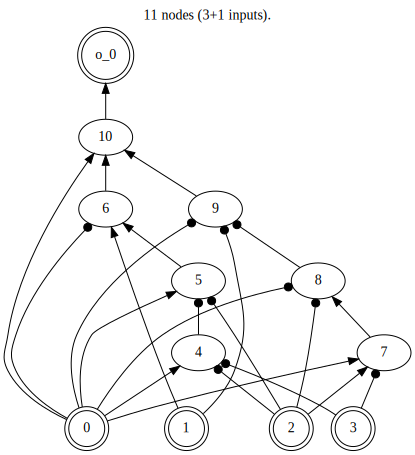

In [20]:
from ipywidgets import interact, IntSlider

invmove = pymig.PyMove(1, 7)
optimized_moved = pymig.apply_move(optimized_decomp, invmove)
viz_graphs = [optimized_decomp.plot(), optimized_moved.plot(), optimum_graph.plot()]

interact(lambda t: viz_graphs[t], t=IntSlider(min=0, max=len(viz_graphs)-1))

In [18]:
optimized_decomp.get_moves()

[Move(1:Inverted Propagation,[4]),
 Move(1:Inverted Propagation,[5]),
 Move(1:Inverted Propagation,[6]),
 Move(1:Inverted Propagation,[7]),
 Move(1:Inverted Propagation,[8]),
 Move(1:Inverted Propagation,[9]),
 Move(1:Inverted Propagation,[10])]

In [2]:
amb_mig = pymig.mig_expression_decompose(4, "<<abc>c<cda>>")
move_mig = pymig.apply_move(amb_mig, pymig.PyMove(1,1))
assert(move_mig.equals(amb_mig))
ambopt = pymig.get_optimum_mig(amb_mig)
moveopt = pymig.get_optimum_mig(move_mig)
assert(ambopt.equals(moveopt))
assert(ambopt.equals(move_mig))
amb_mig.get_moves()

[Move(1:Inverted Propagation,[0]),
 Move(1:Inverted Propagation,[1]),
 Move(1:Inverted Propagation,[2]),
 Move(1:Inverted Propagation,[3]),
 Move(1:Inverted Propagation,[4]),
 Move(1:Inverted Propagation,[5]),
 Move(1:Inverted Propagation,[6]),
 Move(1:Inverted Propagation,[7]),
 Move(4:Swap,[7, 2]),
 Move(4:Swap,[7, 4]),
 Move(5:Swap3,[7, 5, 1]),
 Move(5:Swap3,[7, 5, 2]),
 Move(5:Swap3,[7, 6, 1]),
 Move(5:Swap3,[7, 6, 4])]

In [8]:
testmig = pymig.apply_move(amb_mig, pymig.PyMove(1, 1))
print(testmig.equals(amb_mig))
testmig2 = pymig.apply_move(testmig, pymig.PyMove(1, 0))
print(testmig2.equals(amb_mig))
#graphs_moves = exhaustive_optimize(amb_mig, 3)
#print(len(graphs_moves))
#best, best_moves = select_best(graphs_moves)
#print(best.get_total_nr_nodes())t

True
False


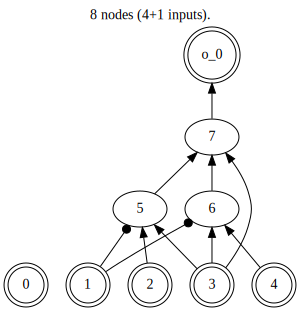

In [6]:
from ipywidgets import interact, IntSlider

viz_graphs = [amb_mig.plot(), testmig.plot(), testmig2.plot(), ambopt.plot(), move_mig.plot(), moveopt.plot()]

interact(lambda t: viz_graphs[t], t=IntSlider(min=0, max=len(viz_graphs)-1))